--- Rozpoczynanie przetwarzania ---
Wczytano plik lokalny: 8.webp
Wymiary obrazu: 800x532
Cel: Zachowanie 90.0% informacji.
Kanał Czerwony (R): wymagane k = 1
Kanał Zielony (G): wymagane k = 1
Kanał Niebieski (B): wymagane k = 3

Średnie k: 1
Teoretyczny stopień kompresji (dla macierzy): ok. 0.00


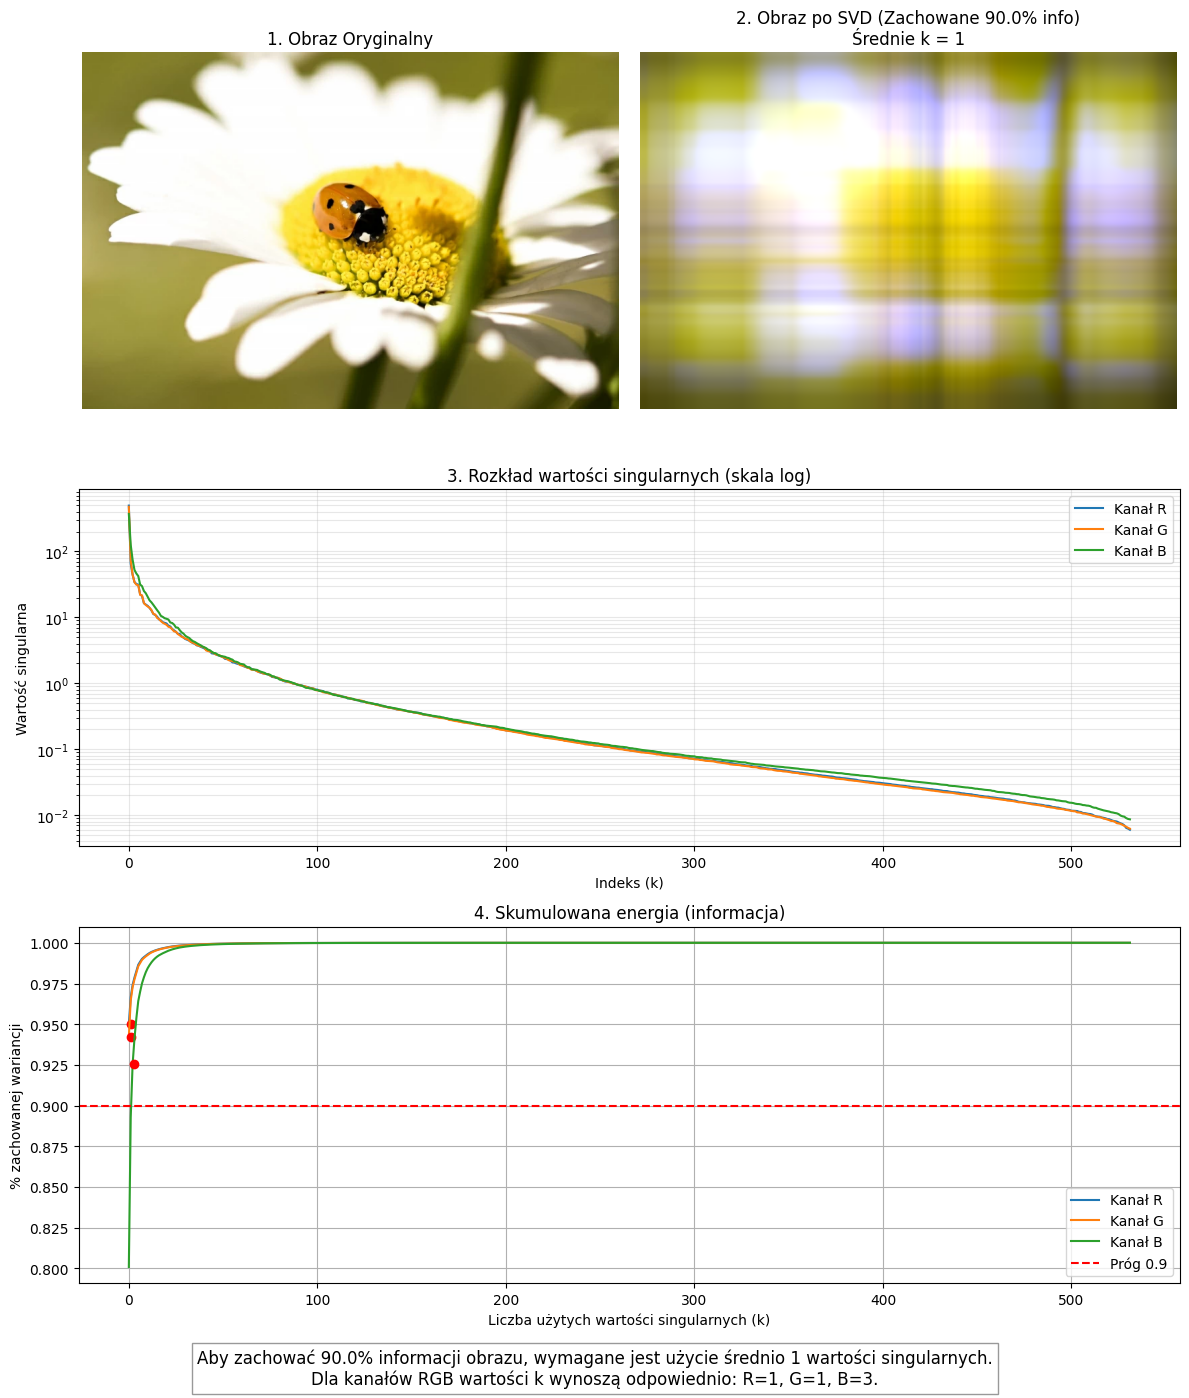

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

IMAGE_FILENAME = '8.webp'
INFO_THRESHOLD = 0.90

print("--- Rozpoczynanie przetwarzania ---")

if os.path.exists(IMAGE_FILENAME):
    img_original = io.imread(IMAGE_FILENAME)
    print(f"Wczytano plik lokalny: {IMAGE_FILENAME}")


img_float = img_original.astype(float) / 255.0

if img_float.shape[2] == 4:
    img_float = img_float[:, :, :3]

def process_svd_channel(channel_data, threshold):
    U, S, Vt = np.linalg.svd(channel_data, full_matrices=False)
    energy = S ** 2
    total_energy = np.sum(energy)
    cumulative_energy = np.cumsum(energy) / total_energy
    k = np.argmax(cumulative_energy >= threshold) + 1
    reconstructed = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
    return reconstructed, k, S, cumulative_energy

height, width, channels = img_float.shape
img_reconstructed = np.zeros_like(img_float)
k_values = []
singular_values_list = []

colors = ['Czerwony (R)', 'Zielony (G)', 'Niebieski (B)']

print(f"Wymiary obrazu: {width}x{height}")
print(f"Cel: Zachowanie {INFO_THRESHOLD*100}% informacji.")

for i in range(3):
    rec, k, S, cum_energy = process_svd_channel(img_float[:, :, i], INFO_THRESHOLD)
    img_reconstructed[:, :, i] = rec
    k_values.append(k)
    singular_values_list.append((S, cum_energy))
    print(f"Kanał {colors[i]}: wymagane k = {k}")

img_reconstructed = np.clip(img_reconstructed, 0, 1)

avg_k = int(np.mean(k_values))
compression_ratio = (avg_k * (height + width + 1)) / (height * width)
print(f"\nŚrednie k: {avg_k}")
print(f"Teoretyczny stopień kompresji (dla macierzy): ok. {compression_ratio:.2f}")

fig = plt.figure(figsize=(12, 14))
gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img_original)
ax1.set_title("1. Obraz Oryginalny")
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img_reconstructed)
ax2.set_title(f"2. Obraz po SVD (Zachowane {INFO_THRESHOLD*100}% info)\nŚrednie k = {avg_k}")
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, :])
for i, (S, _) in enumerate(singular_values_list):
    ax3.plot(S, label=f'Kanał {["R","G","B"][i]}')
ax3.set_yscale('log')
ax3.set_title("3. Rozkład wartości singularnych (skala log)")
ax3.set_ylabel("Wartość singularna")
ax3.set_xlabel("Indeks (k)")
ax3.legend()
ax3.grid(True, which="both", alpha=0.3)

ax4 = fig.add_subplot(gs[2, :])
for i, (_, cum_E) in enumerate(singular_values_list):
    ax4.plot(cum_E, label=f'Kanał {["R","G","B"][i]}')
    k_curr = k_values[i]
    val_curr = cum_E[k_curr-1]
    ax4.plot(k_curr, val_curr, 'ro')

ax4.axhline(y=INFO_THRESHOLD, color='r', linestyle='--', label=f'Próg {INFO_THRESHOLD}')
ax4.set_title("4. Skumulowana energia (informacja)")
ax4.set_ylabel("% zachowanej wariancji")
ax4.set_xlabel("Liczba użytych wartości singularnych (k)")
ax4.legend()
ax4.grid(True)

fig.text(0.5, 0.02,
         f"Aby zachować {INFO_THRESHOLD*100}% informacji obrazu, "
         f"wymagane jest użycie średnio {avg_k} wartości singularnych.\n"
         f"Dla kanałów RGB wartości k wynoszą odpowiednio: R={k_values[0]}, G={k_values[1]}, B={k_values[2]}.",
         ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout(rect=[0, 0.05, 1, 1])

plt.show()